<a href="https://colab.research.google.com/github/surajslab/WeatherInAustraliaPrediction/blob/main/DecisionTrees_Hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rainfall Prediction in Australia**

In [1]:
# Necessary Modules
!pip install numpy pandas opendatasets matplotlib seaborn sklearn --quiet



In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import opendatasets as od
import os

%matplotlib inline



In [3]:
dataset_url="https://www.kaggle.com/jsphyg/weather-dataset-rattle-package"

In [4]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: surajdev
Your Kaggle Key: ··········


100%|██████████| 3.83M/3.83M [00:00<00:00, 20.6MB/s]


In [5]:
os.listdir('weather-dataset-rattle-package')

['weatherAUS.csv']

In [6]:
dataset_path = 'weather-dataset-rattle-package/weatherAUS.csv'

In [7]:
raw_df=pd.read_csv(dataset_path)

In [8]:
raw_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [9]:
list(raw_df.columns)

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow']

In [10]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

In [11]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

# **Preparing the dataset**
## **Steps Involved**
 * Create a train/test/validation split
 * Identify input and target columns
 * Identify numeric and categorical columns
 * Impute (fill) missing numeric values
 * Scale numeric values to the (0,1) range
 * Encode categorical columns to one-hot vectors

# Training, Validation and Test Sets

Extracting the year from the date

In [12]:
year=pd.DatetimeIndex(raw_df['Date']).year

In [13]:
train_df=raw_df[year<2015]
val_df=raw_df[year==2015]
test_df=raw_df[year>2015]


In [14]:
print(f"Training Dataset Shape   : {train_df.shape}")
print(f"Validation Dataset Shape : {val_df.shape}")
print(f"Test Dataset Shape       : {test_df.shape}")


Training Dataset Shape   : (98988, 23)
Validation Dataset Shape : (17231, 23)
Test Dataset Shape       : (25974, 23)


## Identifying Input and Output Columns

In [15]:
input_cols= list(raw_df.columns)[1:-1]
output_cols='RainTomorrow'


In [16]:
train_inputs = train_df[input_cols].copy()
train_target= train_df[output_cols].copy()

val_inputs = val_df[input_cols].copy()
val_target = val_df[output_cols].copy()

test_inputs = test_df[input_cols].copy()
test_target = test_df[output_cols].copy()
train_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144548,Uluru,16.9,33.2,0.0,NaN,NaN,SSE,43.0,ESE,SSE,24.0,26.0,22.0,13.0,1014.1,1009.8,NaN,NaN,23.7,31.8,No
144549,Uluru,15.1,36.8,0.0,NaN,NaN,NE,31.0,ENE,SW,19.0,20.0,16.0,8.0,1012.6,1007.6,NaN,NaN,28.9,34.8,No
144550,Uluru,17.3,37.8,0.0,NaN,NaN,ESE,39.0,ESE,SSE,26.0,9.0,15.0,8.0,1011.9,1008.0,NaN,NaN,29.7,35.7,No
144551,Uluru,20.1,38.5,0.0,NaN,NaN,ESE,43.0,ESE,SSW,28.0,17.0,22.0,9.0,1014.0,1009.2,NaN,NaN,29.8,37.2,No


In [17]:
numeric_cols= train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols= train_df.select_dtypes('object').columns.tolist()[1:-1]


In [18]:
numeric_cols,categorical_cols


(['MinTemp',
  'MaxTemp',
  'Rainfall',
  'Evaporation',
  'Sunshine',
  'WindGustSpeed',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Cloud9am',
  'Cloud3pm',
  'Temp9am',
  'Temp3pm'],
 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

## Imputation

In [19]:
from sklearn.impute import SimpleImputer


In [20]:
imputer= SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])

In [21]:
train_inputs[numeric_cols]  =  imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols]    =  imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols]   =  imputer.transform(test_inputs[numeric_cols])


# Scaling Numerical Features

In [22]:
train_inputs.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000
mean,12.002823,23.003328,2.372704,5.355452,7.611475,40.213769,14.101045,18.768900,68.654275,51.501499,1017.530858,1015.149778,4.354706,4.447402,16.828607,21.526705
std,6.331572,6.983092,8.475680,3.125083,2.907069,13.226474,8.942506,8.826241,18.873780,20.618122,6.731053,6.660441,2.292363,2.136544,6.374509,6.809602
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-5.900000,-5.100000
25%,7.500000,17.900000,0.000000,3.800000,7.500000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.400000,1010.900000,3.000000,3.000000,12.200000,16.600000
50%,11.800000,22.400000,0.000000,5.469824,7.624853,39.000000,13.000000,19.000000,69.000000,52.000000,1017.653758,1015.258204,4.437189,4.503167,16.600000,21.000000
75%,16.600000,27.900000,0.800000,5.600000,9.200000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.300000,6.000000,6.000000,21.300000,26.100000
max,33.900000,48.100000,371.000000,82.400000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.100000


In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler().fit(raw_df[numeric_cols])

train_inputs[numeric_cols]  =  scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols]    =  scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols]   =  scaler.transform(test_inputs[numeric_cols])


In [24]:
train_inputs.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000
mean,0.483557,0.525583,0.006395,0.036934,0.524929,0.265223,0.108470,0.215734,0.686543,0.515015,0.612080,0.608796,0.483856,0.494156,0.506933,0.516827
std,0.149330,0.132006,0.022845,0.021552,0.200488,0.102531,0.068789,0.101451,0.188738,0.206181,0.111257,0.106567,0.254707,0.237394,0.134483,0.130703
min,0.000000,0.013233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030400,0.000000,0.000000,0.027426,0.005758
25%,0.377358,0.429112,0.000000,0.026207,0.517241,0.193798,0.053846,0.149425,0.570000,0.370000,0.543802,0.540800,0.333333,0.333333,0.409283,0.422265
50%,0.478774,0.514178,0.000000,0.037723,0.525852,0.255814,0.100000,0.218391,0.690000,0.520000,0.614112,0.610531,0.493021,0.500352,0.502110,0.506718
75%,0.591981,0.618147,0.002156,0.038621,0.634483,0.310078,0.146154,0.275862,0.830000,0.650000,0.682645,0.675200,0.666667,0.666667,0.601266,0.604607
max,1.000000,1.000000,1.000000,0.568276,0.986207,1.000000,0.669231,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988484


# One Hot Encoding

In [25]:
from sklearn.preprocessing import OneHotEncoder


In [26]:
raw_df[categorical_cols]=raw_df[categorical_cols].fillna("unknown")

train_inputs[categorical_cols]=train_inputs[categorical_cols].fillna("unknown")
val_inputs[categorical_cols]=val_inputs[categorical_cols].fillna("unknown")
test_inputs[categorical_cols]=test_inputs[categorical_cols].fillna("unknown")

In [27]:
encoder=OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols= list(encoder.get_feature_names(categorical_cols))

In [28]:
train_inputs[encoded_cols]  =  encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols]    =  encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols]   =  encoder.transform(test_inputs[categorical_cols])

In [29]:
train_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,...,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_unknown,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_unknown,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_unknown,RainToday_No,RainToday_Yes,RainToday_unknown
0,Albury,0.516509,0.523629,0.001617,0.037723,0.525852,W,0.294574,W,WNW,0.153846,0.275862,0.71,0.22,0.449587,0.4800,0.888889,0.500352,0.508439,0.522073,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,Albury,0.375000,0.565217,0.000000,0.037723,0.525852,WNW,0.294574,NNW,WSW,0.030769,0.252874,0.44,0.25,0.497521,0.4912,0.493021,0.500352,0.514768,0.570058,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,Albury,0.504717,0.576560,0.000000,0.037723,0.525852,WSW,0.310078,W,WSW,0.146154,0.298851,0.38,0.30,0.447934,0.5056,0.493021,0.222222,0.594937,0.548944,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,Albury,0.417453,0.620038,0.000000,0.037723,0.525852,NE,0.139535,SE,E,0.084615,0.103448,0.45,0.16,0.613223,0.5712,0.493021,0.500352,0.533755,0.612284,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Albury,0.613208,0.701323,0.002695,0.037723,0.525852,W,0.271318,ENE,NW,0.053846,0.229885,0.82,0.33,0.500826,0.4624,0.777778,0.888889,0.527426,0.673704,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144548,Uluru,0.599057,0.718336,0.000000,0.037723,0.525852,SSE,0.286822,ESE,SSE,0.184615,0.298851,0.22,0.13,0.555372,0.5232,0.493021,0.500352,0.651899,0.714012,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
144549,Uluru,0.556604,0.786389,0.000000,0.037723,0.525852,NE,0.193798,ENE,SW,0.146154,0.229885,0.16,0.08,0.530579,0.4880,0.493021,

# Curating only the required features

In [30]:
x_train=train_inputs[numeric_cols+encoded_cols]
x_val=val_inputs[numeric_cols+encoded_cols]
x_test=test_inputs[numeric_cols+encoded_cols]


# Preparing the Decision Tree Model

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
model=DecisionTreeClassifier(random_state=42)

In [33]:
%%time
model.fit(x_train,train_target)

CPU times: user 3.11 s, sys: 8.03 ms, total: 3.12 s
Wall time: 3.11 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

## Accuracy And Evaluation

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [35]:
train_preds=model.predict(x_train)

In [36]:
f"{int(accuracy_score(train_preds,train_target) * 100)} % Accuracy"

'99 % Accuracy'

## Checking On The Validation Set

model.score is a functionality in sklearn which does both predictions and automatically prints the accuracy of the model by comparing the predicted results with the actual targets

In [37]:
model.score(x_val,val_target)

0.7921188555510418

In [38]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

In [39]:
pd.DataFrame({
    'feature':x_train.columns,
    'feature importance':model.feature_importances_
    


}).sort_values('feature importance',ascending=False)

,feature,feature importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465
...,...,...
57,Location_Uluru,0.000397
116,RainToday_No,0.000286
64,Location_Woomera,0.000281
40,Location_Newcastle,0.000274


# Regularization

The hyperparameter max_depth is restricted to 3 to avoid **overfitting**.

In [40]:
model=DecisionTreeClassifier(max_depth=3,random_state=42)
model.fit(x_train,train_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [41]:
from sklearn.tree import plot_tree

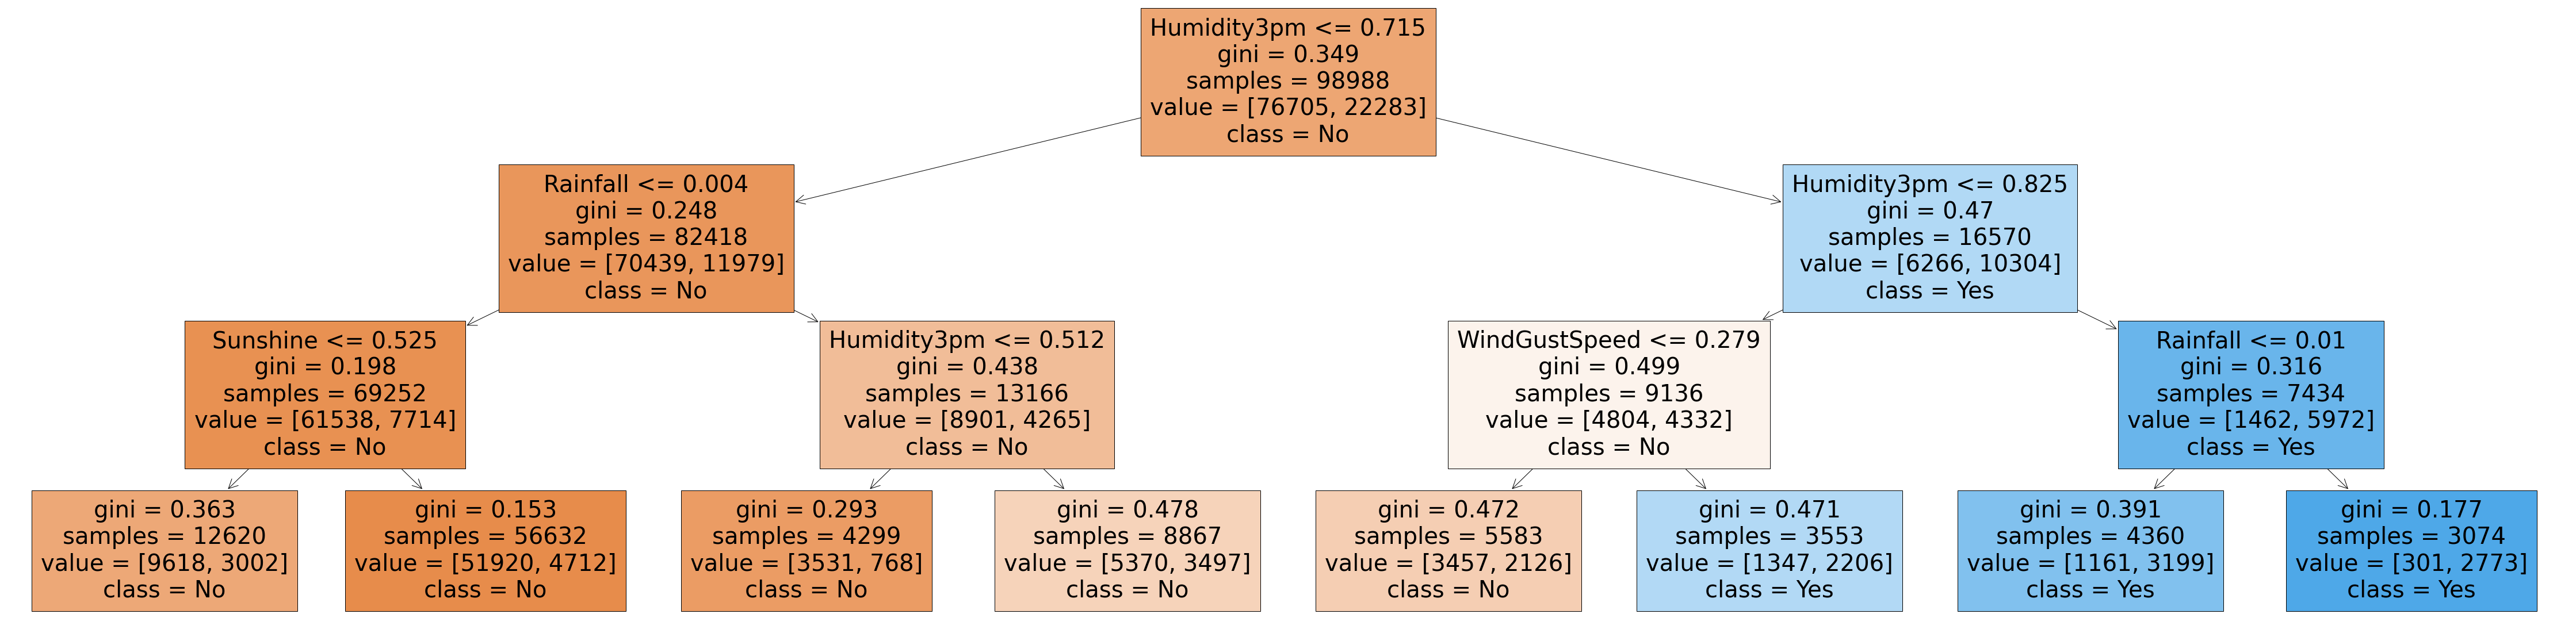

In [42]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=x_train.columns, max_depth=3, filled=True, class_names=model.classes_);

In [43]:
model.score(x_train,train_target)

0.8291308037337859

There is a significant increase in model accuracy in the validation set after modifying the hyperparameter !

In [44]:
model.score(x_val,val_target)

0.8334397307178921

## Finding the right value for the maximum depth.

In [48]:
def max_depth_error(md):

  model=DecisionTreeClassifier(max_depth=md,random_state=42)
  model.fit(x_train,train_target)
  train_error = 1-model.score(x_train,train_target)
  val_error   = 1-model.score(x_val,val_target)

  return {"Max Depth":md, "Training error":train_error,"Validation Error":val_error}





In [49]:
error_df = pd.DataFrame([max_depth_error(md) for md in range(1,21)])


In [50]:
error_df

,Max Depth,Training error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157333


### From the above error_df it is noted that max_depth **7** is the best hyperpameter for the model. 

In [60]:
model=DecisionTreeClassifier(max_depth=7, random_state=42)
model.fit(x_train,train_target)
accuracy=model.score(x_val,val_target)
f'The accuracy of the model on the validation set is {int(accuracy*100)}%'

'The accuracy of the model on the validation set is 84%'